In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_label_path = "/content/drive/MyDrive/캡스톤/Test/labels"
train_label_path = "/content/drive/MyDrive/캡스톤/Training/labels"
test_photo_path = "/content/drive/MyDrive/캡스톤/Test/photo"
train_photo_path = "/content/drive/MyDrive/캡스톤/Training/photo"

Epoch 1, Loss: 570122.5449
Epoch 2, Loss: 349149.0451
Epoch 3, Loss: 348905.5951
Epoch 4, Loss: 348498.9109
Epoch 5, Loss: 348187.4101
Epoch 6, Loss: 347919.1038
Epoch 7, Loss: 347796.3635
Epoch 8, Loss: 347435.5699
Epoch 9, Loss: 347190.3908
Epoch 10, Loss: 346964.2066
Memory usage after training: 4814.51171875 MB


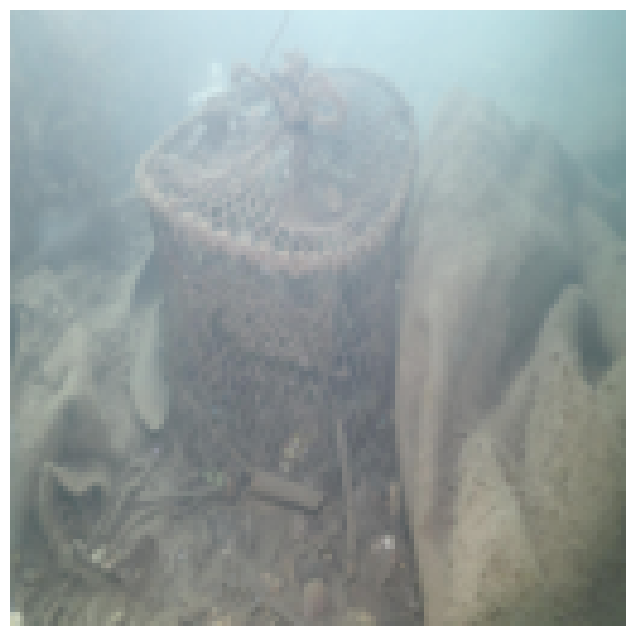

In [ ]:
import numpy as np
from PIL import Image
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc
import psutil
import cv2

# 하이퍼파라미터 설정
GRID_SIZE = 7               # 그리드 크기 (7x7)
EPOCHS = 10                  # 학습 반복 횟수
LR = 0.001                   # 학습률
BATCH_SIZE = 4               # 배치 사이즈
IMAGE_SIZE = 128             # 입력 이미지 크기
HIDDEN_UNITS = 256           # 은닉층 유닛 수

# 데이터 경로 설정
train_label_path = "/content/drive/MyDrive/캡스톤/Training/labels"
train_photo_path = "/content/drive/MyDrive/캡스톤/Training/photo"
test_label_path = "/content/drive/MyDrive/캡스톤/Test/labels"
test_photo_path = "/content/drive/MyDrive/캡스톤/Test/photo"

# 무시할 라벨 리스트
IGNORE_LABELS = {"other objects", "othe objects", "other objets"}

# XML 파일에서 박스 정보 추출 함수
def extract_boxes(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        if label in IGNORE_LABELS:
            continue
        b = obj.find('bndbox')
        try:
            box = {
                'xmin': float(b.find('xmin').text),
                'ymin': float(b.find('ymin').text),
                'xmax': float(b.find('xmax').text),
                'ymax': float(b.find('ymax').text)
            }
        except ValueError:
            continue
        boxes.append(box)
    return filename, boxes

# 감마 보정 함수
def apply_gamma_correction(img_array, gamma=1.5):
    # img_array: (H, W, 3) 형태로, 값은 0~1 범위
    img = np.clip(img_array, 0, 1)  # 값이 0~1 범위를 벗어나지 않도록 클리핑
    img = (img * 255).astype(np.uint8)  # [0, 1] -> [0, 255] 범위로 변환 후 uint8 타입으로 변경

    inv_gamma = 1.0 / gamma  # 감마 보정의 역수 계산
    # LUT 테이블을 만들어 감마 보정 수행을 빠르게 할 수 있도록 함
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")

    # OpenCV의 LUT 함수를 사용하여 감마 보정 적용
    img_corrected = cv2.LUT(img, table)  # LUT 테이블을 이용해 이미지 보정
    return img_corrected / 255.0  # 다시 0~1 범위로 정규화하여 반환

# 데이터 로드 함수 (감마 보정 포함)
def load_data_with_gamma(label_path, image_path, gamma=1.5):
    data = []
    for file in os.listdir(label_path):
        if not file.endswith(".xml"):
            continue
        filename, boxes = extract_boxes(os.path.join(label_path, file))  # XML 파일에서 박스 정보 추출
        image_file = os.path.join(image_path, filename)
        if not os.path.exists(image_file):
            continue
        img = Image.open(image_file).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))  # 이미지 로드 후 크기 변경
        img = np.array(img) / 255.0  # [0, 255] -> [0, 1] 범위로 정규화

        img = apply_gamma_correction(img, gamma=gamma)  # 감마 보정 적용

        label = np.zeros((GRID_SIZE, GRID_SIZE, 10))  # 각 그리드 셀에 대해 라벨 초기화
        for box in boxes:
            # 바운딩 박스의 좌표를 그리드 상의 비율로 변환
            x_center = (box['xmin'] + box['xmax']) / 2 / IMAGE_SIZE
            y_center = (box['ymin'] + box['ymax']) / 2 / IMAGE_SIZE
            width = (box['xmax'] - box['xmin']) / IMAGE_SIZE
            height = (box['ymax'] - box['ymin']) / IMAGE_SIZE
            # 그리드 위치 계산
            grid_x = min(int(x_center * GRID_SIZE), GRID_SIZE - 1)
            grid_y = min(int(y_center * GRID_SIZE), GRID_SIZE - 1)
            # 첫 번째 바운딩 박스 정보 저장
            if label[grid_y, grid_x, 0] == 0:
                label[grid_y, grid_x, 0] = 1
                label[grid_y, grid_x, 1:5] = [x_center, y_center, width, height]
            # 두 번째 바운딩 박스 정보 저장
            elif label[grid_y, grid_x, 5] == 0:
                label[grid_y, grid_x, 5] = 1
                label[grid_y, grid_x, 6:10] = [x_center, y_center, width, height]
        data.append((img, label))
    return data


# ReLU 함수
def relu(x):
    return np.maximum(0, x)

# ReLU의 미분 함수
def relu_deriv(x):
    return (x > 0).astype(float)

# 모델 초기화 함수
def init_model():
    input_dim = IMAGE_SIZE * IMAGE_SIZE * 3  # 입력 이미지 크기 (128x128) * 3 (RGB 채널)
    output_dim = GRID_SIZE * GRID_SIZE * 10  # 출력 크기: 7x7 그리드, 2개의 박스를 예측하기 위해 10
    W1 = np.random.randn(HIDDEN_UNITS, input_dim) * 0.01  # 첫 번째 가중치
    b1 = np.zeros((HIDDEN_UNITS,))  # 첫 번째 편향
    W2 = np.random.randn(output_dim, HIDDEN_UNITS) * 0.01  # 두 번째 가중치
    b2 = np.zeros((output_dim,))  # 두 번째 편향
    return W1, b1, W2, b2

# 예측 함수
def predict(img, W1, b1, W2, b2):
    x = img.flatten()  # 이미지를 1차원 배열로 변환
    h = relu(W1 @ x + b1)  # 첫 번째 레이어에 대한 계산 (ReLU 활성화 함수 적용)
    out = W2 @ h + b2  # 두 번째 레이어 계산
    return out.reshape((GRID_SIZE, GRID_SIZE, 10)), h, x

# 손실 함수 및 기울기 계산 함수
def loss_and_grad(pred, label, h, x, W2, W1):
    loss = 0
    dW2 = np.zeros_like(W2)
    db2 = np.zeros((W2.shape[0],))
    dW1 = np.zeros_like(W1)
    db1 = np.zeros((W1.shape[0],))

    pred_flat = pred.reshape(-1, 10)  # 예측 값을 1차원 배열로 평탄화
    label_flat = label.reshape(-1, 10)  # 실제 값을 1차원 배열로 평탄화

    for i in range(len(pred_flat)):
        if label_flat[i][0] == 1:  # 객체가 있을 경우
            diff = pred_flat[i] - label_flat[i]  # 예측과 실제의 차이
            loss += np.sum(diff ** 2)  # 손실값 계산 (MSE)
            d_out = 2 * diff  # 출력에 대한 기울기 계산
            dW2[i*10:i*10+10] += np.outer(d_out, h)  # 두 번째 가중치 기울기
            db2[i*10:i*10+10] += d_out  # 두 번째 편향 기울기

            # 첫 번째 레이어에 대한 기울기
            d_hidden = W2[i*10:i*10+10].T @ d_out * relu_deriv(h)
            dW1 += np.outer(d_hidden, x)
            db1 += d_hidden
    return loss, dW1, db1, dW2, db2

# 모델 학습 함수
def train_model(W1, b1, W2, b2, data):
    for epoch in range(EPOCHS):
        np.random.shuffle(data)  # 데이터를 섞음
        total_loss = 0
        for i in range(0, len(data), BATCH_SIZE):
            batch = data[i:i+BATCH_SIZE]
            batch_loss = 0
            dW1 = np.zeros_like(W1)
            db1 = np.zeros_like(b1)
            dW2 = np.zeros_like(W2)
            db2 = np.zeros_like(b2)
            for img, label in batch:
                pred, h, x = predict(img, W1, b1, W2, b2)
                loss, dw1, db_1, dw2, db_2 = loss_and_grad(pred, label, h, x, W2, W1)
                batch_loss += loss
                dW1 += dw1
                db1 += db_1
                dW2 += dw2
                db2 += db_2
            W1 -= LR * dW1 / BATCH_SIZE  # 가중치 업데이트
            b1 -= LR * db1 / BATCH_SIZE  # 편향 업데이트
            W2 -= LR * dW2 / BATCH_SIZE
            b2 -= LR * db2 / BATCH_SIZE
            total_loss += batch_loss
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        gc.collect()  # 가비지 컬렉션 실행
    return W1, b1, W2, b2

# 예측 결과 시각화 함수
def visualize(img, pred):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for k in range(2):  # 두 개의 박스를 예측
                conf = pred[i, j, k * 5]
                if conf > 0.5:  # 신뢰도 50% 이상일 때만 박스를 그림
                    x, y, w, h = pred[i, j, k * 5 + 1: k * 5 + 5]
                    xmin = int((x - w / 2) * IMAGE_SIZE)
                    ymin = int((y - h / 2) * IMAGE_SIZE)
                    width = int(w * IMAGE_SIZE)
                    height = int(h * IMAGE_SIZE)
                    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
    plt.axis('off')  # 축 제거
    plt.show()

# 메모리 사용량 확인 함수
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

# 학습 실행
train_data = load_data_with_gamma(train_label_path, train_photo_path, gamma=1.5)
test_data = load_data_with_gamma(test_label_path, test_photo_path, gamma=1.5)

W1, b1, W2, b2 = init_model()
W1, b1, W2, b2 = train_model(W1, b1, W2, b2, train_data)

print("Memory usage after training:", get_memory_usage(), "MB")

test_img, _ = test_data[0]
pred, _, _ = predict(test_img, W1, b1, W2, b2)
visualize(test_img, pred)


In [ ]:
import numpy as np

def compute_iou(box1, box2):
    x, y, w, h = box1
    x2, y2, w2, h2 = box2
    box1 = [x - w/2, y - h/2, x + w/2, y + h/2]
    box2 = [x2 - w2/2, y2 - h2/2, x2 + w2/2, y2 + h2/2]

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def extract_pred_boxes(pred, threshold=0.01):
    boxes = []
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for k in range(2):
                confidence = pred[i, j, k * 5]
                if confidence > threshold:
                    x, y, w, h = pred[i, j, k * 5 + 1: k * 5 + 5]
                    boxes.append([confidence, x, y, w, h])
    return boxes

def extract_true_boxes(label):
    boxes = []
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            for k in range(2):
                if label[i, j, k * 5] == 1:
                    x, y, w, h = label[i, j, k * 5 + 1: k * 5 + 5]
                    boxes.append([x, y, w, h])
    return boxes

def calculate_ap(pred_boxes, true_boxes, iou_threshold=0.5):
    if len(true_boxes) == 0:
        return 0.0

    pred_boxes = sorted(pred_boxes, key=lambda x: -x[0])

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched = set()

    for i, pred in enumerate(pred_boxes):
        pred_conf, px, py, pw, ph = pred
        best_iou = 0
        best_idx = -1
        for j, true in enumerate(true_boxes):
            iou = compute_iou([px, py, pw, ph], true)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou >= iou_threshold and best_idx not in matched:
            tp[i] = 1
            matched.add(best_idx)
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)

    recalls = cum_tp / (len(true_boxes) + 1e-6)
    precisions = cum_tp / (cum_tp + cum_fp + 1e-6)


    for i in range(len(precisions) - 1, 0, -1):
        precisions[i-1] = np.maximum(precisions[i-1], precisions[i])


    ap = 0.0
    recall_thresholds = np.linspace(0, 1, 11)
    for t in recall_thresholds:
        precisions_at_recall = precisions[recalls >= t]
        if precisions_at_recall.size > 0:
            ap += np.max(precisions_at_recall)
    ap /= len(recall_thresholds)

    return ap

def calculate_mAP(test_data):
    ap_total = 0
    for img, label in test_data:
        pred, _, _ = predict(img, W1, b1, W2, b2)
        pred_boxes = extract_pred_boxes(pred)
        true_boxes = extract_true_boxes(label)
        ap = calculate_ap(pred_boxes, true_boxes)
        ap_total += ap
    mAP = ap_total / len(test_data)
    return mAP


mAP = calculate_mAP(test_data)
print(f"mAP: {mAP:.4f}")

mAP: 0.3870
